In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
from keras.constraints import Constraint
import pickle

In [2]:
DEFAULT_BETA_BJORCK = 0.5
DEFAULT_EPS_SPECTRAL = 1e-3
DEFAULT_EPS_BJORCK = 1e-3
DEFAULT_MAXITER_BJORCK = 15
DEFAULT_MAXITER_SPECTRAL = 10
SWAP_MEMORY = True
STOP_GRAD_SPECTRAL = True

def reshaped_kernel_orthogonalization(
    kernel,
    u,
    adjustment_coef,
    eps_spectral=DEFAULT_EPS_SPECTRAL,
    eps_bjorck=DEFAULT_EPS_BJORCK,
    beta=DEFAULT_BETA_BJORCK,
    maxiter_spectral=DEFAULT_MAXITER_SPECTRAL,
    maxiter_bjorck=DEFAULT_MAXITER_BJORCK,
):
    """
    Perform reshaped kernel orthogonalization (RKO) to the kernel given as input. It
    apply the power method to find the largest singular value and apply the Bjorck
    algorithm to the rescaled kernel. This greatly improve the stability and and
    speed convergence of the bjorck algorithm.

    Args:
        kernel (tf.Tensor): the kernel to orthogonalize
        u (tf.Tensor): the vector used to do the power iteration method
        adjustment_coef (float): the adjustment coefficient as used in convolution
        eps_spectral (float): stopping criterion in spectral algorithm
        eps_bjorck (float): stopping criterion in bjorck algorithm
        beta (float): the beta used in the bjorck algorithm
        maxiter_spectral (int): maximum number of iterations for the power iteration
        maxiter_bjorck (int): maximum number of iterations for bjorck algorithm

    Returns:
        tf.Tensor: the orthogonalized kernel, the new u, and sigma which is the largest
            singular value

    Reference:
        Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
        Achieving robustness in classification using optimal transport with hinge regularization. 
        In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).
        
    """
    W_shape = kernel.shape
    # Flatten the Tensor
    W_reshaped = tf.reshape(kernel, [-1, W_shape[-1]])
    W_bar, u, sigma = spectral_normalization(
        W_reshaped, u, eps=eps_spectral, maxiter=maxiter_spectral
    )
    if (eps_bjorck is not None) and (beta is not None):
        W_bar = bjorck_normalization(
            W_bar, eps=eps_bjorck, beta=beta, maxiter=maxiter_bjorck
        )
    W_bar = W_bar * adjustment_coef
    W_bar = K.reshape(W_bar, kernel.shape)
    return W_bar, u, sigma


def _wwtw(w):
    if w.shape[0] > w.shape[1]:
        return w @ (tf.transpose(w) @ w)
    else:
        return (w @ tf.transpose(w)) @ w


def bjorck_normalization(
    w, eps=DEFAULT_EPS_BJORCK, beta=DEFAULT_BETA_BJORCK, maxiter=DEFAULT_MAXITER_BJORCK
):
    """
    apply Bjorck normalization on w.

    Args:
        w (tf.Tensor): weight to normalize, in order to work properly, we must have
            max_eigenval(w) ~= 1
        eps (float): epsilon stopping criterion: norm(wt - wt-1) must be less than eps
        beta (float): beta used in each iteration, must be in the interval ]0, 0.5]
        maxiter (int): maximum number of iterations for the algorithm

    Returns:
        tf.Tensor: the orthonormal weights

    Reference:
        Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
        Achieving robustness in classification using optimal transport with hinge regularization. 
        In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).
        
    """
    # create a fake old_w that does'nt pass the loop condition
    # it won't affect computation as the first action done in the loop overwrite it.
    old_w = 10 * w
    # define the loop condition

    def cond(w, old_w):
        return tf.linalg.norm(w - old_w) >= eps

    # define the loop body
    def body(w, old_w):
        old_w = w
        w = (1 + beta) * w - beta * _wwtw(w)
        return w, old_w

    # apply the loop
    w, old_w = tf.while_loop(
        cond,
        body,
        (w, old_w),
        parallel_iterations=30,
        maximum_iterations=maxiter,
        swap_memory=SWAP_MEMORY,
    )
    return w


def _power_iteration(
    linear_operator,
    adjoint_operator,
    u,
    eps=DEFAULT_EPS_SPECTRAL,
    maxiter=DEFAULT_MAXITER_SPECTRAL,
    axis=None,
):
    """Internal function that performs the power iteration algorithm to estimate the
    largest singular vector of a linear operator.

    Args:
        linear_operator (Callable): a callable object that maps a linear operation.
        adjoint_operator (Callable): a callable object that maps the adjoint of the
            linear operator.
        u (tf.Tensor): initialization of the singular vector.
        eps (float, optional): stopping criterion of the algorithm, when
            norm(u[t] - u[t-1]) is less than eps. Defaults to DEFAULT_EPS_SPECTRAL.
        maxiter (int, optional): maximum number of iterations for the algorithm.
            Defaults to DEFAULT_MAXITER_SPECTRAL.
        axis (int/list, optional): dimension along which to normalize. Can be set for
            depthwise convolution for example. Defaults to None.

    Returns:
        tf.Tensor: the maximum singular vector.
    
    Reference:
        Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
        Achieving robustness in classification using optimal transport with hinge regularization. 
        In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).
        
    """

    # Prepare while loop variables
    u = tf.math.l2_normalize(u, axis=axis)
    # create a fake old_w that doesn't pass the loop condition, it will be overwritten
    old_u = u + 2 * eps

    # Loop body
    def body(u, old_u):
        old_u = u
        v = linear_operator(u)
        u = adjoint_operator(v)

        u = tf.math.l2_normalize(u, axis=axis)

        return u, old_u

    # Loop stopping condition
    def cond(u, old_u):
        return tf.linalg.norm(u - old_u) >= eps

    # Run the while loop
    u, _ = tf.while_loop(
        cond,
        body,
        (u, old_u),
        maximum_iterations=maxiter,
        swap_memory=SWAP_MEMORY,
    )

    # Prevent gradient to back-propagate into the while loop
    if STOP_GRAD_SPECTRAL:
        u = tf.stop_gradient(u)

    return u


def spectral_normalization(
    kernel, u, eps=DEFAULT_EPS_SPECTRAL, maxiter=DEFAULT_MAXITER_SPECTRAL
):
    """
    Normalize the kernel to have its maximum singular value equal to 1.

    Args:
        kernel (tf.Tensor): the kernel to normalize, assuming a 2D kernel.
        u (tf.Tensor): initialization of the maximum singular vector.
        eps (float, optional): stopping criterion of the algorithm, when
            norm(u[t] - u[t-1]) is less than eps. Defaults to DEFAULT_EPS_SPECTRAL.
        maxiter (int, optional): maximum number of iterations for the algorithm.
            Defaults to DEFAULT_MAXITER_SPECTRAL.

    Returns:
        the normalized kernel, the maximum singular vector, and the maximum singular
            value.

    Reference:
        Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
        Achieving robustness in classification using optimal transport with hinge regularization. 
        In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).
        
    """

    if u is None:
        u = tf.random.uniform(
            shape=(1, kernel.shape[-1]), minval=0.0, maxval=1.0, dtype=kernel.dtype
        )

    def linear_op(u):
        return u @ tf.transpose(kernel)

    def adjoint_op(v):
        return v @ kernel

    u = _power_iteration(linear_op, adjoint_op, u, eps, maxiter)

    # Compute the largest singular value and the normalized kernel.
    # We assume that in the worst case we converged to sigma + eps (as u and v are
    # normalized after each iteration)
    # In order to be sure that operator norm of normalized kernel is strictly less than
    # one we use sigma + eps, which ensures stability of Björck algorithm even when
    # beta=0.5
    sigma = tf.reshape(tf.norm(linear_op(u)), (1, 1))
    normalized_kernel = kernel / (sigma + eps)
    return normalized_kernel, u, sigma

In [3]:
class SpectralConstraint(Constraint):
    def __init__(
        self,
        k_coef_lip=1.0,
        eps_spectral=DEFAULT_EPS_SPECTRAL,
        eps_bjorck=DEFAULT_EPS_BJORCK,
        beta_bjorck=DEFAULT_BETA_BJORCK,
        u=None,
    ) -> None:
        
        """
        Ensure that *all* singular values of the weight matrix equals to 1. Computation
        based on Bjorck algorithm. The computation is done in two steps:

        1. reduce the larget singular value to k_coef_lip, using iterate power method.
        2. increase other singular values to k_coef_lip, using bjorck algorithm.

        Args:
            k_coef_lip (float): lipschitz coefficient of the weight matrix
            eps_spectral (float): stopping criterion for the iterative power algorithm.
            eps_bjorck (float): stopping criterion Bjorck algorithm.
            beta_bjorck (float): beta parameter in bjorck algorithm.
            u (tf.Tensor): vector used for iterated power method, can be set to None
                (used for serialization/deserialization purposes).

        Reference:
            Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
            Achieving robustness in classification using optimal transport with hinge regularization. 
            In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).
            
        """
        
        self.eps_spectral = eps_spectral
        self.eps_bjorck = eps_bjorck
        self.beta_bjorck = beta_bjorck
        self.k_coef_lip = k_coef_lip
        if not (isinstance(u, tf.Tensor) or (u is None)):
            u = tf.convert_to_tensor(u)
        self.u = u
        super(SpectralConstraint, self).__init__()

    def __call__(self, w):
        # make the largest singular value of W to be 1
        wbar, _, _ = reshaped_kernel_orthogonalization(
            w,
            self.u,
            self.k_coef_lip,
            self.eps_spectral,
            self.eps_bjorck,
            self.beta_bjorck,
        )

        # clip to ensure non-negative weight
        wbar = K.clip(wbar, 0, wbar)
        return wbar

    def get_config(self):
        config = {
            "k_coef_lip": self.k_coef_lip,
            "eps_spectral": self.eps_spectral,
            "eps_bjorck": self.eps_bjorck,
            "beta_bjorck": self.beta_bjorck,
            "u": None if self.u is None else self.u.numpy(),
        }
        base_config = super(SpectralConstraint, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [32]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*10
test_loss = [0]*10
noise = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(1):
    X_train = np.load("data/X_train.npy")
    X_test = np.load("data/X_test.npy")
    y_train = np.load("data/y_train.npy")
    y_test_normalized = np.load("data/y_test_normalized.npy")

    y_train = y_train + np.random.normal(0, noise[i], y_train.shape)

    # ICLRNN
    input = Input(shape=(X_train.shape[1],X_train.shape[2]))
    x = SimpleRNN(64, activation='relu', return_sequences=True, kernel_constraint=SpectralConstraint())(input)
    x = SimpleRNN(64, activation='relu', return_sequences=False, kernel_constraint=SpectralConstraint())(x)
    x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
    model = Model(input, x)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
    history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.25, verbose=2)
    training_loss[i] = history.history['val_loss'][-1]
    print(training_loss)

    loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
    test_loss[i] = loss[0]
    print(test_loss)

    name = 'iclrnn_64_'
    name = name + str(noise[i]) + '.h5'
    model.save(name)

model.summary()

Epoch 1/50
1402/1402 - 13s - loss: 0.1837 - mean_squared_error: 0.1837 - val_loss: 0.0711 - val_mean_squared_error: 0.0711 - 13s/epoch - 9ms/step
Epoch 2/50
1402/1402 - 11s - loss: 0.0882 - mean_squared_error: 0.0882 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - 11s/epoch - 7ms/step
Epoch 3/50
1402/1402 - 10s - loss: 0.0865 - mean_squared_error: 0.0865 - val_loss: 0.0657 - val_mean_squared_error: 0.0657 - 10s/epoch - 7ms/step
Epoch 4/50
1402/1402 - 11s - loss: 0.0859 - mean_squared_error: 0.0859 - val_loss: 0.0663 - val_mean_squared_error: 0.0663 - 11s/epoch - 8ms/step
Epoch 5/50
1402/1402 - 14s - loss: 0.0857 - mean_squared_error: 0.0857 - val_loss: 0.0655 - val_mean_squared_error: 0.0655 - 14s/epoch - 10ms/step
Epoch 6/50
1402/1402 - 14s - loss: 0.0853 - mean_squared_error: 0.0853 - val_loss: 0.0649 - val_mean_squared_error: 0.0649 - 14s/epoch - 10ms/step
Epoch 7/50
1402/1402 - 15s - loss: 0.0849 - mean_squared_error: 0.0849 - val_loss: 0.0657 - val_mean_squared_error: 0.0657

 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 13058 (51.01 KB)
Trainable params: 13058 (51.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)),flush=True)
model.summary()

The FLOPs is:26114
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 8)]           0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 15, 64)            4672      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 13058 (51.01 KB)
Trainable params: 13058 (51.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
X_train = np.load("data/X_train.npy")
X_test = np.load("data/X_test.npy")
y_train = np.load("data/y_train.npy")
y_test_normalized = np.load("data/y_test_normalized.npy")
y_test = np.load("data/y_test.npy")

scaler_X = pickle.load(open("data/scalar_X.sav", 'rb'))
scaler_y = pickle.load(open("data/scalar_y.sav", 'rb'))
model = tf.keras.models.load_model('iclrnn_256_0.h5', custom_objects={'SpectralConstraint': SpectralConstraint})

y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,2)

787/787 [==============================] - 7s 8ms/step
(25180, 2)


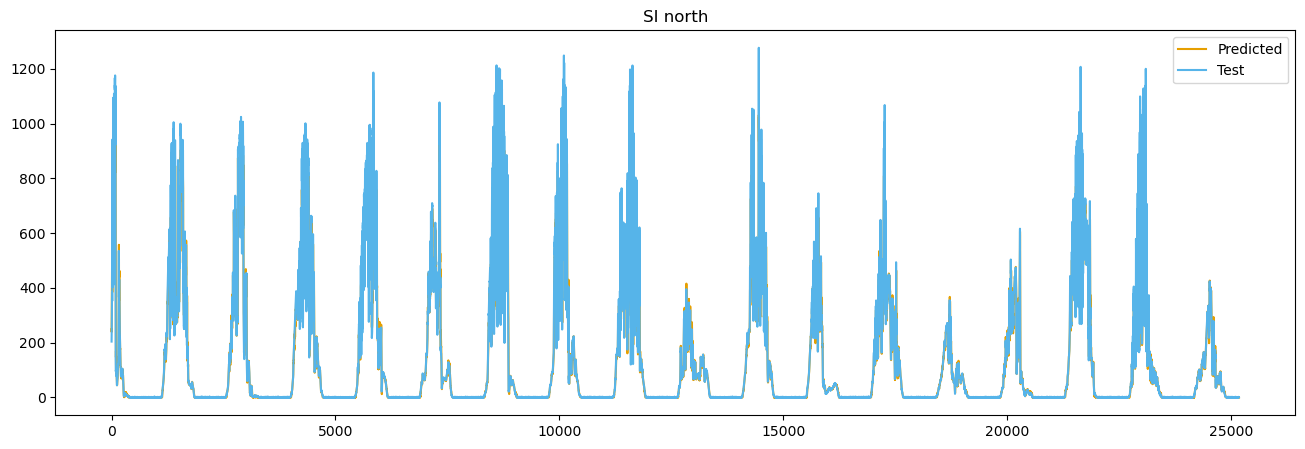

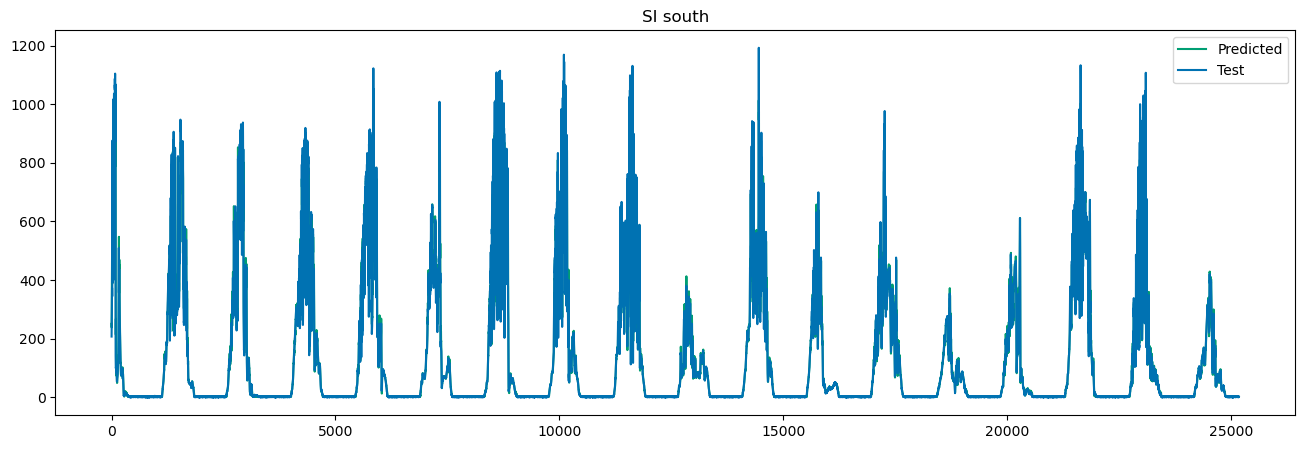

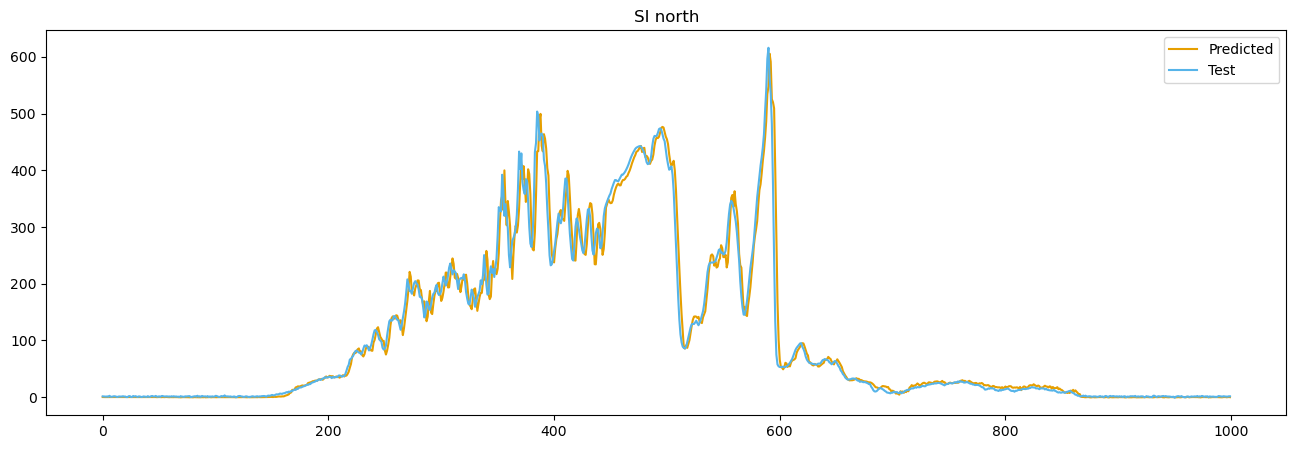

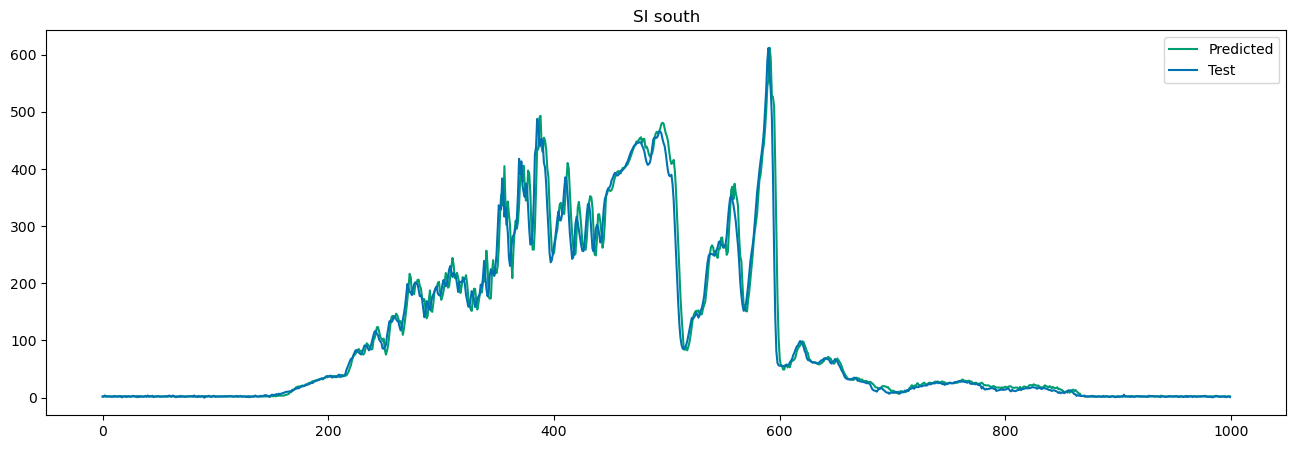

In [5]:
# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(16, 5))
plt.plot(y_predict[:,0], color="#E69F00", label='Predicted')
plt.plot(y_test[:,0], color="#56B4E9", label='Test')
plt.title("SI north")
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(y_predict[:,1], color="#009E73", label='Predicted')
plt.plot(y_test[:,1], color="#0072B2", label='Test')
plt.title("SI south")
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(y_predict[19700:20700,0], color="#E69F00", label='Predicted')
plt.plot(y_test[19700:20700,0], color="#56B4E9", label='Test')
plt.title("SI north")
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(y_predict[19700:20700,1], color="#009E73", label='Predicted')
plt.plot(y_test[19700:20700,1], color="#0072B2", label='Test')
plt.title("SI south")
plt.legend()
plt.show()

6/6 [==============================] - 0s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060 
loss:  [0.005986032076179981, 0.005986032076179981]


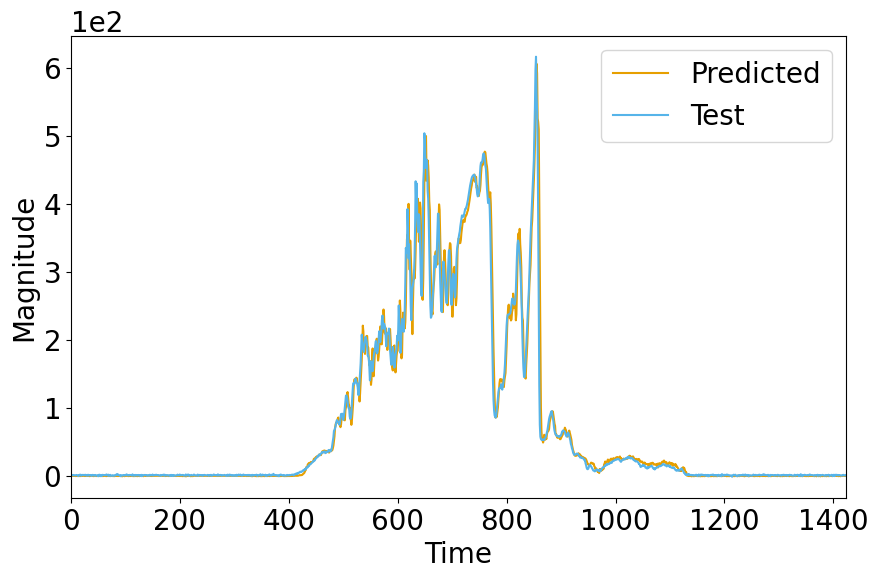

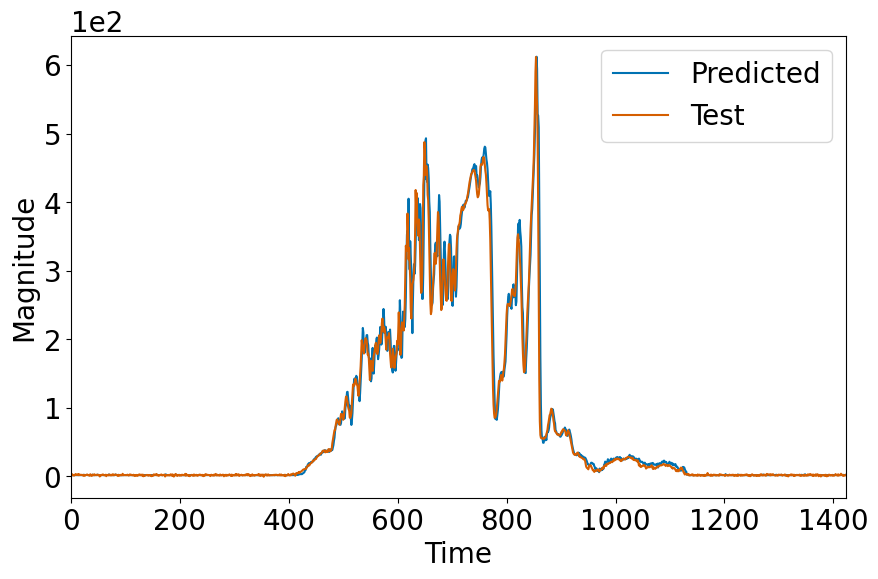

In [7]:
# apply to unseen data
# 2023-12-28
data_new = pd.read_csv('data/2023-12/[170] 2023-12-28.txt',sep='	')

SI_data = data_new[['Tm', 'AvgGmod05_N_1','AvgGmod05_S_1', 'AvgHamb_1', 'AvgTamb_1', 'AvgTmod05_N_1', 'AvgTmod05_S_1', 'AvgWindS_1', 'AvgWindD_1']]
SI_data = SI_data.set_index('Tm')

SI_north = SI_data['AvgGmod05_N_1'].to_numpy()
SI_south = SI_data['AvgGmod05_S_1'].to_numpy()
Ambient_humidity = SI_data['AvgHamb_1'].to_numpy()
Ambient_temp = SI_data['AvgTamb_1'].to_numpy()
Temp_north = SI_data['AvgTmod05_N_1'].to_numpy()
Temp_south = SI_data['AvgTmod05_S_1'].to_numpy()
Wind_speed = SI_data['AvgWindS_1'].to_numpy()
Wind_direction = SI_data['AvgWindD_1'].to_numpy()

def generate_data(data):
  win_length = 15
  count = 0
  data_train = []
  data_test = []
  while count < len(data):
    if count + win_length + 1 < len(data):
      data_train.append(data[count:count+win_length])
      data_test.append(data[count+win_length+1])
      count = count + 1
    else:
      break
  return np.array(data_train).reshape(-1, win_length, 1), np.array(data_test).reshape(-1, 1)

SI_north_train, SI_north_test = generate_data(SI_north)
SI_south_train, SI_south_test = generate_data(SI_south)
Ambient_humidity_train, Ambient_humidity_test = generate_data(Ambient_humidity)
Ambient_temp_train, Ambient_temp_test = generate_data(Ambient_temp)
Temp_north_train, Temp_north_test = generate_data(Temp_north)
Temp_south_train, Temp_south_test = generate_data(Temp_south)
Wind_speed_train, Wind_speed_test = generate_data(Wind_speed)
Wind_direction_train, Wind_direction_test = generate_data(Wind_direction)

data_train = np.concatenate([SI_south_train, SI_north_train, Ambient_humidity_train, Ambient_temp_train, Temp_north_train, Temp_south_train, Wind_speed_train, Wind_direction_train], axis=2)
data_test = np.concatenate([SI_south_test, SI_north_test], axis=1)

win_length = 15
X = scaler_X.transform(data_train.reshape(-1, 8)).reshape(-1, win_length, 8)
y = scaler_y.transform(data_test.reshape(-1, 2)).reshape(-1, 2)

y_predict = model.predict(X)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,2)

loss = model.evaluate(X, y, batch_size=256)
print('loss: ', loss)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10, 6))
plt.rc('font', size=20)
plt.plot(y_predict[:,0], color="#E69F00", label='Predicted')
plt.plot(data_test[:,0], color="#56B4E9", label='Test')
# plt.title("SI north")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('si_north_iclrnn_256_testing.pdf')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_predict[:,1], color="#0072B2", label='Predicted')
plt.plot(data_test[:,1], color="#D55E00", label='Test')
# plt.title("SI south")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('si_south_iclrnn_256_testing.pdf')
plt.show()

5/5 [==============================] - 0s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041   
loss:  [0.004064228385686874, 0.004064228385686874]


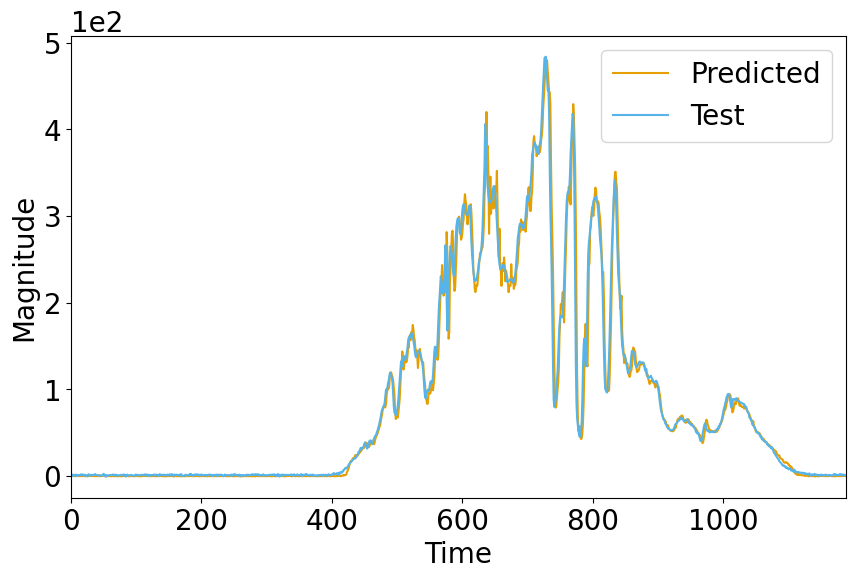

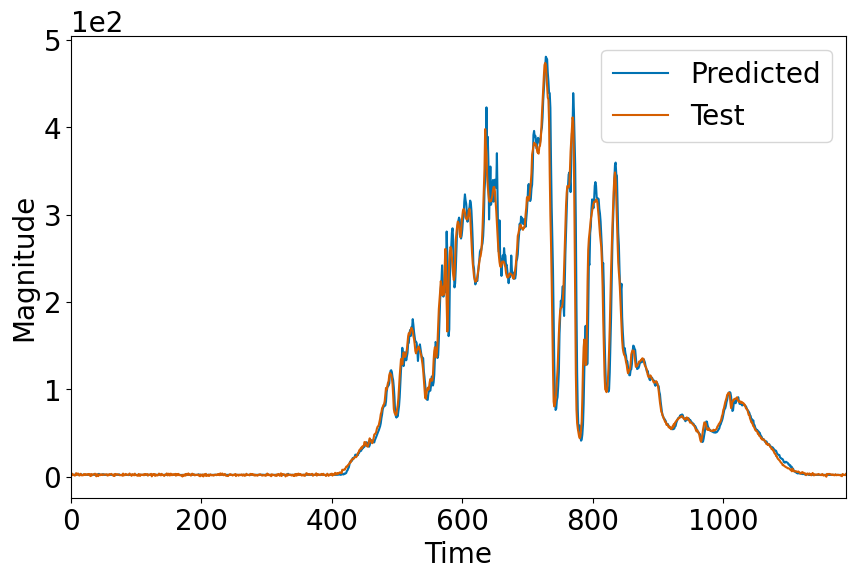

In [8]:
# apply to unseen data
# 2024-01-01
data_new = pd.read_csv('data/2024-01/[170] 2024-01-01.txt',sep='	')

SI_data = data_new[['Tm', 'AvgGmod05_N_1','AvgGmod05_S_1', 'AvgHamb_1', 'AvgTamb_1', 'AvgTmod05_N_1', 'AvgTmod05_S_1', 'AvgWindS_1', 'AvgWindD_1']]
SI_data = SI_data.set_index('Tm')

SI_north = SI_data['AvgGmod05_N_1'].to_numpy()
SI_south = SI_data['AvgGmod05_S_1'].to_numpy()
Ambient_humidity = SI_data['AvgHamb_1'].to_numpy()
Ambient_temp = SI_data['AvgTamb_1'].to_numpy()
Temp_north = SI_data['AvgTmod05_N_1'].to_numpy()
Temp_south = SI_data['AvgTmod05_S_1'].to_numpy()
Wind_speed = SI_data['AvgWindS_1'].to_numpy()
Wind_direction = SI_data['AvgWindD_1'].to_numpy()

def generate_data(data):
  win_length = 15
  count = 0
  data_train = []
  data_test = []
  while count < len(data):
    if count + win_length + 1 < len(data):
      data_train.append(data[count:count+win_length])
      data_test.append(data[count+win_length+1])
      count = count + 1
    else:
      break
  return np.array(data_train).reshape(-1, win_length, 1), np.array(data_test).reshape(-1, 1)

SI_north_train, SI_north_test = generate_data(SI_north)
SI_south_train, SI_south_test = generate_data(SI_south)
Ambient_humidity_train, Ambient_humidity_test = generate_data(Ambient_humidity)
Ambient_temp_train, Ambient_temp_test = generate_data(Ambient_temp)
Temp_north_train, Temp_north_test = generate_data(Temp_north)
Temp_south_train, Temp_south_test = generate_data(Temp_south)
Wind_speed_train, Wind_speed_test = generate_data(Wind_speed)
Wind_direction_train, Wind_direction_test = generate_data(Wind_direction)

data_train = np.concatenate([SI_south_train, SI_north_train, Ambient_humidity_train, Ambient_temp_train, Temp_north_train, Temp_south_train, Wind_speed_train, Wind_direction_train], axis=2)
data_test = np.concatenate([SI_south_test, SI_north_test], axis=1)

win_length = 15
X = scaler_X.transform(data_train.reshape(-1, 8)).reshape(-1, win_length, 8)
y = scaler_y.transform(data_test.reshape(-1, 2)).reshape(-1, 2)

y_predict = model.predict(X)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,2)

loss = model.evaluate(X, y, batch_size=256)
print('loss: ', loss)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10, 6))
plt.rc('font', size=20)
plt.plot(y_predict[:,0], color="#E69F00", label='Predicted')
plt.plot(data_test[:,0], color="#56B4E9", label='Test')
# plt.title("SI north")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('si_north_iclrnn_256_unseen.pdf')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_predict[:,1], color="#0072B2", label='Predicted')
plt.plot(data_test[:,1], color="#D55E00", label='Test')
# plt.title("SI south")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('si_south_iclrnn_256_unseen.pdf')
plt.show()